## Data Collection and Preprocessing

In [26]:
import math
import pandas as pd
import os
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# Initialize dictionaries of dataframes

data = {}
years = [18, 19, 20, 21, 22, 23]


In [4]:
# Obtain data

for x in years:
    data[x] = pd.read_csv('../cleanData/refined/pbp_refined_20' + str(x) + '.csv')

print("Done")

Done


/var/folders/z2/rm0rvjws51g2b4p7_0ns_31w0000gp/T/ipykernel_93230/962884901.py:4: DtypeWarning: Columns (30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data[x] = pd.read_csv('../cleanData/refined/pbp_refined_20' + str(x) + '.csv')


In [5]:
# Create one large dataframe of all the data

df = pd.concat(data, ignore_index=True)

In [13]:
df.columns

#print(df.info())

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Unnamed: 0_pbp', 'play_id', 'game_id',
       'old_game_id', 'home_team', 'away_team', 'season_type', 'week',
       'posteam', 'posteam_type', 'defteam', 'side_of_field', 'yardline_100',
       'game_date', 'quarter_seconds_remaining', 'game_seconds_remaining',
       'qtr', 'down', 'time', 'ydstogo', 'play_type', 'yards_gained',
       'no_huddle', 'qb_scramble', 'pass_length', 'pass_location', 'air_yards',
       'yards_after_catch', 'run_location', 'run_gap',
       'posteam_timeouts_remaining', 'total_home_score', 'total_away_score',
       'posteam_score', 'defteam_score', 'score_differential',
       'score_differential_post', 'no_score_prob', 'ep', 'epa', 'wp', 'def_wp',
       'home_wp', 'away_wp', 'wpa', 'season', 'play_type_nfl', 'out_of_bounds',
       'Unnamed: 0_pbp_part', 'nflverse_game_id', 'possession_team',
       'offense_formation', 'offense_personnel', 'defenders_in_box',
       'defense_personnel', 'number_of_pass_rushers', 'n

In [21]:
# Filter data based on 2 min drill

df = df[df['offense_personnel'] == '1 RB, 1 TE, 3 WR']
df = df[df['qtr'] == 4]
df = df[df['quarter_seconds_remaining'] <= 120]

df.dropna(subset=['epa'], inplace=True) # For some reason there is a NaN for EPA in 18385

print(df.shape)

(5030, 64)


In [22]:
# Encode categorical features

le_route = LabelEncoder()
df['route_encoded'] = le_route.fit_transform(df['route'])

le_coverage = LabelEncoder()
df['coverage_encoded'] = le_coverage.fit_transform(df['defense_coverage_type'])

le_pressure = LabelEncoder()
df['pressure_encoded'] = le_pressure.fit_transform(df['was_pressure'])

le_length = LabelEncoder()
df['length_encoded'] = le_length.fit_transform(df['pass_length'])

le_location = LabelEncoder()
df['location_encoded'] = le_location.fit_transform(df['pass_location'])


print(df.shape)

(5030, 69)


## Model Implementation

In [23]:
#X = df[['yardline_100', 'quarter_seconds_remaining', 'ydstogo', 'play_type', 'yards_gained', 'no_huddle', 'qb_scramble', 'pass_length', 
#        'pass_location', 'air_yards', 'yards_after_catch', 'run_location', 'run_gap', 'score_differential', 'epa', 'out_of_bounds',
#        'offense_formation', 'offense_personnel', 'defenders_in_box', 'defense_personnel', 'number_of_pass_rushers', 'ngs_air_yards',
#        'time_to_throw', 'was_pressure', 'route']]

X = df[['yardline_100', 'quarter_seconds_remaining', 'down', 'ydstogo', 'no_huddle', 'length_encoded', 'location_encoded', 'out_of_bounds',
        'posteam_timeouts_remaining', 'defenders_in_box', 'number_of_pass_rushers', 'time_to_throw', 'pressure_encoded', 
        'route_encoded', 'coverage_encoded', 'score_differential_post']]

y = df[['epa']]


In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, = train_test_split(
    X, y, test_size=0.2, random_state=97
)

# Initialize model to tune
model_epa_basic = xgb.XGBRegressor(objective="reg:squarederror")

# Define the parameter grid
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}


In [38]:
# Use RandomizedSearchCV to explore hyperparameter space
random_search = RandomizedSearchCV(estimator=model_epa_basic, param_distributions=param_dist, 
                                   n_iter=100, scoring='neg_mean_squared_error', cv=5)

random_search.fit(X_train, y_train)

# Get the best parameters
print("Best parameters found: ", random_search.best_params_)

# In case you don't want to execute the search, the results were the following:
# Best parameters found: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

Best parameters found:  {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


In [39]:
# Train XGBoost regression model to predict EPA based on tuned paramters

best_params = random_search.best_params_

model_epa = xgb.XGBRegressor(objective="reg:squarederror", **best_params)

model_epa.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Model Evaluation

In [40]:
# Make predictions based on testing data

y_pred = model_epa.predict(X_test)


In [41]:
# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)

# Calculate MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE (Root Mean Squared Error)
rmse = math.sqrt(mse)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)

# Display the evaluation metrics
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 0.7896533645212676
Mean Squared Error (MSE): 1.486128868613122
Root Mean Squared Error (RMSE): 1.219068853105977
R-squared (R²): 0.19953396363425824


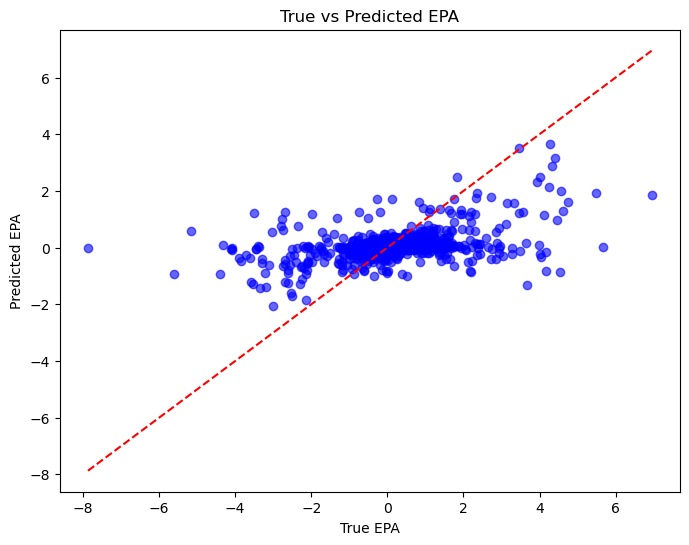

In [42]:
# Visualize Model
# Plot true vs predicted EPA values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Line of perfect prediction
plt.title('True vs Predicted EPA')
plt.xlabel('True EPA')
plt.ylabel('Predicted EPA')
plt.show()

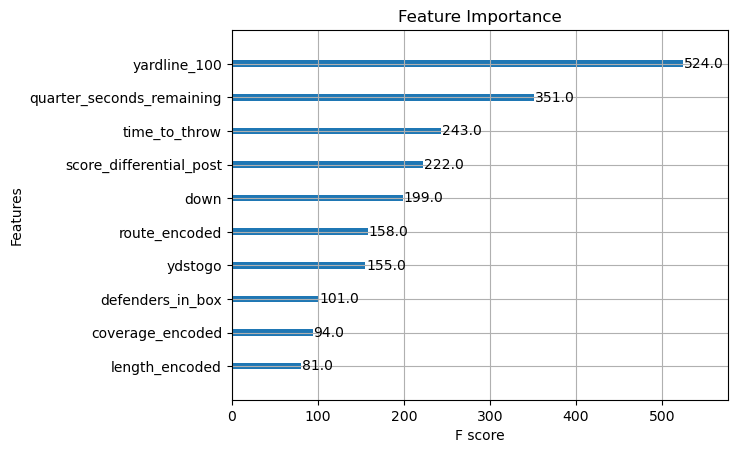

In [43]:
# Plot feature importances
xgb.plot_importance(model_epa, importance_type='weight', max_num_features=10)
plt.title('Feature Importance')
plt.show()

## Prediction Test

In [44]:
# Get coverages
coverages = data[x]['defense_coverage_type'].unique()
print(coverages)

['COVER_3' 'COVER_4' 'COVER_1' 'COVER_0' 'COVER_6' 'COVER_2' '2_MAN'
 'PREVENT']


In [45]:
# encode test features

predict_route = le_route.transform(['OUT'])[0]
predict_pressure = le_pressure.transform([False])[0]
predict_length = le_length.transform(['short'])[0]
predict_location = le_location.transform(['left'])[0]


In [114]:
# Create dataframe to predict on

#X = df[['yardline_100', 'quarter_seconds_remaining', 'ydstogo', 'no_huddle', 'pass_length', 'pass_location', 'air_yards', 'out_of_bounds',
#        'defenders_in_box', 'number_of_pass_rushers', 'time_to_throw', 'was_pressure', 'route', 'defense_coverage_type']]

predict_data = pd.DataFrame()

for x in coverages:
    new_row = {
        'yardline_100' : 75,
        'quarter_seconds_remaining': 120,
        'down': 1,
        'ydstogo': 10,
        'no_huddle': 0,
        'length_encoded': predict_length,
        'location_encoded': predict_location,
        'out_of_bounds': 1,
        'posteam_timeouts_remaining': 3,
        'defenders_in_box': 7,
        'number_of_pass_rushers': 4,
        'time_to_throw': 2.1,
        'pressure_encoded': False,
        'route_encoded': predict_route,
        'coverage_encoded': le_coverage.transform([[x]]),
        'score_differential_post': -3
    }
    new_data = pd.DataFrame(new_row, index = [0])
    predict_data = pd.concat([predict_data, new_data])

    

/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/opt/homebrew/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_label.

In [116]:
# Create predictions
predicted_epa = model_epa.predict(predict_data)

# Add the predictions to the DataFrame
predict_data['coverage_type'] = le_coverage.inverse_transform(predict_data['coverage_encoded'])
predict_data['predicted_EPA'] = predicted_epa

# Print results
print(predict_data[['coverage_type', 'predicted_EPA']].sort_values(by=['predicted_EPA']))

  coverage_type  predicted_EPA
0       COVER_3       0.130723
0       COVER_4       0.130723
0       COVER_2       0.130723
0       COVER_6       0.143366
0       PREVENT       0.143366
0       COVER_1       0.145682
0       COVER_0       0.164943
0         2_MAN       0.164943


## Additional EDA

In [50]:
print(y.describe())

# Mean is 0.0862, median is -0.0662, the distance between them is around 0.746, or about 0.54 STDs.
# This suggests data is right skewed and we could find a better way to normalize it. Moreover STD is quite high.
# Despite this, I don't think there's enough outliers severely impact data. 
# Additionally, xgboost is a tree-based model, so in theory the effects of outliers should be mitigated.

               epa
count  5030.000000
mean      0.086218
std       1.372957
min      -9.652063
25%      -0.412045
50%      -0.066156
75%       0.645309
max       7.148208


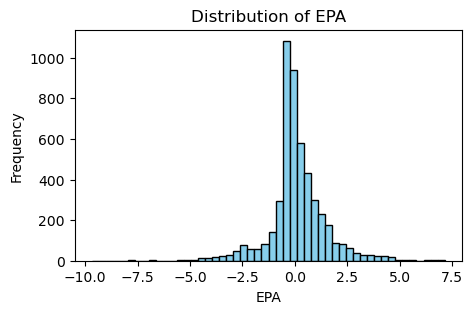

In [53]:
plt.figure(figsize=(5, 3))
plt.hist(y, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of EPA')
plt.xlabel('EPA')
plt.ylabel('Frequency')
plt.show()

In [111]:
Q1 = df['epa'].quantile(0.25)
Q3 = df['epa'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

outliers = df[(df['epa'] < lower_bound) | (df['epa'] > upper_bound)]
print(f"Number of extreme outliers: {len(outliers)}")

Number of extreme outliers: 152


In [118]:
print(df['defense_coverage_type'].value_counts())

defense_coverage_type
COVER_3    1136
COVER_1    1002
COVER_2     919
COVER_4     771
COVER_6     459
COVER_0     293
2_MAN       277
PREVENT     173
Name: count, dtype: int64


## Analysis

$MSE$ is quite high in this context, as it is suggesting the model is off by around 1.478 EPA (even after tuning the model). $R^2$ is also considerably low at poistive 0.19.

While the data for EPA is moderately right-skewed, I don't think that would have substantially impacted the model performance, as xgboost is a tree-based model that mitigates the effects of outliers. Furthermore, the sample size of 5030 plays and the histogram of the EPA distribution suggests that it is generally normal. Still, there are about 152 extreme outliers (i.e. $Q_{1, 3} \pm 3 \times IQR$) out of 5030, which is approximately 3% of the data and may be considered a non-trivial amount.

In general, it seems `COVER 3` generally minimizes EPA and is the most frequent coverage type in these situations.

### Possible Improvements
- Find other regression models that would fit better
  - And see how much outliers are affecting mean errors
- Add more features that better account for playstyle (e.g. QB cluster, team as a feature)
- Add features that account for quality of offense and defense
- Create a tree based on previous plays to get tendencies of offense throughout game
- Account for run
- Find way to generalize inputs (e.g. instead of specific yrdstogo, be able to input range of yrdstogo)
- Add features such as down and score_differential